# Training Yolov5 for Kaggle Competitions  [Setup Tutorial]

## Firstly, look at the data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import imageio
import matplotlib.pyplot as plt

monitor = True
load = True

df = pd.read_csv('../input/tensorflow-great-barrier-reef/train.csv')
display(df)

samples_labeled = df[df['annotations']!='[]']
samples_no_labels = df[df['annotations']=='[]']

print(samples_labeled.shape)
print(samples_no_labels.shape)

fig, axs = plt.subplots(1,1)
names = ['Annotated', 'Not Annotated']
vals = [samples_labeled.shape[0],samples_no_labels.shape[0]]
barlist=axs.bar(names,vals)
barlist[0].set_color('g')
barlist[1].set_color('r')

axs.set_ylabel("Amount of Data Points")
axs.set_title("Amount of annotated vs non-annotated samples")
plt.show()

I'm gonna drop some non-annotated samples so the dataset is more balanced.

In [ ]:
n = abs(samples_labeled.shape[0]-samples_no_labels.shape[0])
samples_to_drop = df[df['annotations']=='[]'].sample(n = n)
display(samples_to_drop.index)

In [ ]:
def annotation_to_list(annotation):
    if annotation.annotations=='[]':
        return []
    annotation_list = []
    an = [int(s.strip('{}').split(': ')[1]) for s  in (annotation.annotations.strip("[]{}")).split(',')]
    box_count = len(an)/4
    for b in range(int(box_count)):
        annotation_list.append(an[b*4:b*4+4])
    return annotation_list

In [ ]:
import matplotlib.patches as patches

n=3
samples = df[df['annotations']!='[]'].sample(n = n)

display(samples)
width=1280
height=720
path = "../input/tensorflow-great-barrier-reef/train_images/video_"
fig, axs = plt.subplots(n,1,figsize=(n*5,n*10))
i=0
j=0
for d in samples.itertuples():
    scatters_x = []
    scatters_y = []
    im = imageio.imread(path + str(d.video_id) + "/" + str(d.image_id.split("-")[1]) + ".jpg")
    for x,y,w,h in annotation_to_list(d):
        rect = patches.Rectangle((x,y), w,h, linewidth=3, edgecolor='r', facecolor='None')
        axs[i].add_patch(rect)
        scatters_x.append(x+w/2)
        scatters_y.append(y+h/2)
        print(x,y,w,h)
    axs[i].imshow(im)
    axs[i].set_title(str(x)+" " + str(y)+" " + str(w)+" " + str(h))
    i+=1
plt.show()

The data is made up of frames for three videos which have annotations attached to them.

The annotation format is as follows :
```
x_min, y_min, width, height
```
in pixel units.

Each image is of size 1280x720

## Setting up the directory structure for the images

First we have to copy over all images to the working directory, as we cannot manipulate the directory structure of the input. This might take a moment, especially for larger datasets.

In [ ]:
!cp -r "../input/tensorflow-great-barrier-reef/train_images" ./

Yolov5 also requires a specific directory structure for the training and validation data. Here is my final directory tree for this specific competition.

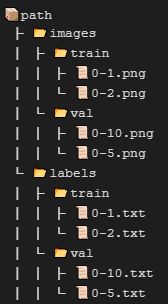

The directory path must align with the data file used as input when training the network later on. 

This is how my data.yaml file looked for this particular competition:
```
path: /kaggle/working/  # dataset root dir
train: ./images/train # train images (relative to 'path') 128 images
val: ./images/val

# Classes
nc: 1  # number of classes
names: ['starfish']  # class names
```

If the train image directory is defined as ./images/train, then the network will look for corresponding labels in ./labels/train. The names of the jpg files in the image directory must correspond exactly to the txt files in the labels directory. 

nc corresponds to the amount of classes that are to be predicted, note that "nothing" is not counted as a class. 

names is a list of names for every class that is to be predicted.

Furthermore, the labels are required to be in "Coco"-format, i.e:
```
class_id x_center y_center width height
```
and all values have to be normalized (between 0-1) with a new line for each annotation. 

This means we must switch the directiory structure as well as reformat the annotations for this dataset.

In [ ]:
def write_to_file(filename,annotations, width=1280,height=720):
    f = open(filename, "w")
    annotations = annotation_to_list(annotations)
    for annotation in annotations:
        x,y,w,h = annotation
        f.write(str(0) + " " + str((x+w/2)/width) + " " + str((y+h/2)/height) + " " + str(w/width) + " " + str(h/height) + "\n")
    f.close()

In [ ]:
import os
import shutil
df["image"] = pd.NaT
df["data_type"] = "train"
i=0
os.makedirs("./labels/train")
os.makedirs("./labels/val")
os.makedirs("./images/train")      
os.makedirs("./images/val") 
val_ratio = 5

for dirname, _, filenames in os.walk('./train_images'):
    for filename in filenames:
        if '.jpg' in filename:
            idx = df[df['image_id']==dirname.split('video_')[1]+'-'+filename.strip('.jpg')].index[0]               
            if idx not in samples_to_drop.index:
                if i%val_ratio==0:
                    os.replace(dirname+"/"+filename, "./images/val/"+df.loc[idx,'image_id']+".jpg")
                    df.loc[idx,'image'] = "./images/val/"+df.loc[idx,'image_id']+".jpg"

                    df.loc[idx,"data_type"] = "val"
                    write_to_file("./labels/val/"+df.loc[idx,'image_id']+".txt", df.loc[idx])

                else:
                    os.replace(dirname+"/"+filename, "./images/train/"+df.loc[idx,'image_id']+".jpg")
                    df.loc[idx,'image'] = "./images/train/"+df.loc[idx,'image_id']+".jpg"
                    write_to_file("./labels/train/"+df.loc[idx,'image_id']+".txt", df.loc[idx])
                i+=1
display(df)

In [ ]:
samples = df[df['image_id'] == '1-9229']
print("Before (Competition Format)")
for i in samples['annotations'].values[0].split('},'):
    print(i.strip(''))
print("-------------------------------")
print("After (CoCo-format):")
!cat {samples['image'].values[0].replace('images','labels').replace('jpg','txt')}

## Network configuration and Training

Network configuration with Yolov5 is defined in a .yaml file that is used as parameter to the train.py script. This files should include number of classes, network depth and width, anchors and finally, the head and backbone of the network.

Since we are transfer-learning, the backbone has to be frozen before training. We don't have to worry about the shape as Yolov5 automatically reshapes input layer.

.yaml files for the different sized yolov5 networks can be found at the ultralytics github.

https://github.com/ultralytics/yolov5/tree/master/models

In [ ]:
!cat ../input/coralreefdata/reef.yaml

In [ ]:
import torch
# Downloading necessary files and yolov5 directory
!git clone https://github.com/ultralytics/yolov5  # clone
%pip install -qr yolov5/requirements.txt  # install

# Setting parameters
EPOCHS = 25
IMG_WIDTH = 1280
IMG_HEIGHT = 720
BATCH_SIZE = 32
data_file = '../input/coralreefdata/reef_data.yaml'
conf_file = '../input/coralreefdata/reef.yaml'

# Make sure you download the correct size network
model = None
model_name = None

if load:
    model_name = '../input/k/yousseftaoudi/training-yolov5-on-competition-data-tutorial/yolov5/runs/train/exp/weights/best.pt'
    model = torch.hub.load('../input/k/yousseftaoudi/training-yolov5-on-competition-data-tutorial/yolov5', 'custom', path=model_name, force_reload=True, source='local')  # custom model
else:
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s') # Pretrained
    model_name = 'yolov5s.pt'


In [ ]:
!ls ../input/k/yousseftaoudi/training-yolov5-on-competition-data-tutorial

Training is done through running the yolov5/train.py file. You need to define a set of parameters in order to run properly.

Relevant Parameters:

- img - Image size = {x}, for accurate results this parameter should be the lonegst dimension of the image.
 
- batch - Batch size = {x}

- epochs - Training epochs = {x}

- data - .yaml file for the data configuration
- weights - pre-trained weights (.pt file), can be found in the yolov5 repository cloned earlier.

- freeze - {x} amount of layers that are to be frozen (size of the backbone) 

- hyp - yaml file defining hyperparameters for the network, default settings are found here: https://github.com/ultralytics/yolov5/blob/4103ce9ad0393cc27f6c80457894ad7be0cb1f0d/data/hyps/hyp.finetune.yaml

- noval - use parameter if you dont want a validation set.

- evolve - will run fine-tuning of a base-network {x} amount of times in order to find the best hyperparameters.

- workers - {x} amount of python threads.

- optimizer - Adam/SGD/AdamW

For this particular network, we will only use a couple of these parameters.

Login to wandb if you want to monitor training. 

In [ ]:
!pip install wandb

In [ ]:
if monitor:
    from kaggle_secrets import UserSecretsClient

    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("api_key")
    !wandb login {secret_value_0}

In [ ]:
!python yolov5/train.py --img {IMG_WIDTH} --batch {BATCH_SIZE} --epochs {EPOCHS}\
    --data {data_file} --cfg {conf_file} --weights {model_name} --freeze 9 --optimizer Adam


Run this and you will get a custom trained .pt yolov5 network on your data!

In [ ]:
import imageio as io
from matplotlib.pyplot import figure
figure(figsize=(25, 10), dpi=80)

results = "yolov5/runs/train/exp/results.png"
im = io.imread(results)
plt.imshow(im)
plt.show()

### Inference on Training images

In [ ]:
import shutil
n=10
samples = df[df['annotations']!='[]'].sample(n = n)

# Best network is saved here
model_name = "yolov5/runs/train/exp/weights/best.pt"


os.makedirs("./test")
for index, row in samples.iterrows():
    print(row.image)
    shutil.copy(row.image,"./test")

!python yolov5/detect.py --weights {model_name} --img-size {IMG_WIDTH} --conf 0.2 --source ./test
fig, axs = plt.subplots(n,1,figsize=(n*10,n*10))

for i, (index, row) in enumerate(samples.iterrows()):
    try:
        print("yolov5/runs/detect/exp/"+row.image.split('/')[3])
        im = imageio.imread("./yolov5/runs/detect/exp/"+row.image.split('/')[3])
        axs[i].imshow(im)
    except:
        print(i,"pass")
        pass
plt.show()

If you're interested in inference and prediction using your trained network on test data/submission data, checkout the inference counterpart of this notebook:

https://www.kaggle.com/yousseftaoudi/help-protect-the-great-barrier-reef-inference

In [ ]:
!rm -r  "./images"
!rm -r  "./labels"
!rm -r  "./train_images"
